In [1]:
from IPython.display import clear_output
!apt-get -y install graphviz graphviz-dev
!pip install tensorflow==2.8 tensorflow-io==0.25.0 tfds-nightly pygraphviz
%pip install tensorflow_gnn==0.2.0
%pip install httplib2==0.20.4
clear_output()

In [2]:
import pygraphviz as pgv
from tqdm import tqdm
from IPython.display import Image
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import tensorflow_gnn as tfgnn
import tensorflow_datasets as tfds
from tensorflow_gnn import runner
from tensorflow_gnn.models import gat_v2
print(f'Using TensorFlow v{tf.__version__} and TensorFlow-GNN v{tfgnn.__version__}')
print(f'GPUs available: {tf.config.list_physical_devices("GPU")}')

Using TensorFlow v2.8.0 and TensorFlow-GNN v0.2.0
GPUs available: []


In [3]:
dataset_splits, dataset_info = tfds.load('cardiotox', data_dir='data/tfds', with_info=True)

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/6523 [00:00<?, ? examples/s]

Shuffling data/tfds/cardiotox/1.0.0.incomplete977SGX/cardiotox-train.tfrecord*...:   0%|          | 0/6523 [00…

Generating validation examples...:   0%|          | 0/1631 [00:00<?, ? examples/s]

Shuffling data/tfds/cardiotox/1.0.0.incomplete977SGX/cardiotox-validation.tfrecord*...:   0%|          | 0/163…

Generating test examples...:   0%|          | 0/839 [00:00<?, ? examples/s]

Shuffling data/tfds/cardiotox/1.0.0.incomplete977SGX/cardiotox-test.tfrecord*...:   0%|          | 0/839 [00:0…

Generating test2 examples...:   0%|          | 0/177 [00:00<?, ? examples/s]

Shuffling data/tfds/cardiotox/1.0.0.incomplete977SGX/cardiotox-test2.tfrecord*...:   0%|          | 0/177 [00:…

Dataset cardiotox downloaded and prepared to data/tfds/cardiotox/1.0.0. Subsequent calls will reuse this data.


In [4]:
graph_schema_pbtxt = """
node_sets {
  key: "atom"
  value {
    description: "An atom in the molecule."

    features {
      key: "atom_features"
      value: {
        description: "[DATA] The features of the atom."
        dtype: DT_FLOAT
        shape { dim { size: 27 } }
      }
    }
  }
}

edge_sets {
  key: "bond"
  value {
    description: "A bond between two atoms in the molecule."
    source: "atom"
    target: "atom"

    features {
      key: "bond_features"
      value: {
        description: "[DATA] The features of the bond."
        dtype: DT_FLOAT
        shape { dim { size: 12 } }
      }
    }
  }
}

context {
  features {
    key: "toxicity"
    value: {
      description: "[LABEL] The toxicity class of the molecule (0 -> non-toxic; 1 -> toxic)."
      dtype: DT_INT64
    }
  }

  features {
    key: "molecule_id"
    value: {
      description: "[LABEL] The id of the molecule."
      dtype: DT_STRING
    }
  }
}
"""

In [5]:
graph_schema = tfgnn.parse_schema(graph_schema_pbtxt)
graph_spec = tfgnn.create_graph_spec_from_schema_pb(graph_schema)

In [6]:
def make_graph_tensor(datapoint):

    """
    Convert a datapoint from the TF-DS CardioTox dataset into a `GraphTensor`.
    """
    # atom_mask is non-zero only for real atoms
    # [ V, ]
    atom_indices = tf.squeeze(tf.where(datapoint['atom_mask']), axis=1)

    # only keep features of real atoms
    # [ V, 27 ]
    atom_features = tf.gather(datapoint['atoms'], atom_indices)

    # restrict the bond mask to real atoms
    # [ V, V ]
    pair_mask = tf.gather(tf.gather(datapoint['pair_mask'], atom_indices, axis=0), atom_indices, axis=1)

    # restrict the bond features to real atoms
    # [ V, V, 12 ]
    pairs = tf.gather(tf.gather(datapoint['pairs'], atom_indices, axis=0), atom_indices, axis=1)

    # pair_mask is non-zero only for real bonds
    # [ E, 2 ]
    bond_indices = tf.where(pair_mask)

    # only keep features of real bonds
    # [ E, 12 ]
    bond_features = tf.gather_nd(pairs, bond_indices)

    # separate sources and targets for each bond
    # [ E, ]
    sources, targets = tf.unstack(tf.transpose(bond_indices))

    # active is [1, 0] for non-toxic molecules, [0, 1] for toxic molecules
    # [ ]
    toxicity = tf.argmax(datapoint['active'])

    # the molecule_id is included for reference
    # [ ]
    molecule_id = datapoint['molecule_id']

    # create a GraphTensor from all of the above
    atom = tfgnn.NodeSet.from_fields(features={'atom_features': atom_features},
                                     sizes=tf.shape(atom_indices))

    atom_adjacency = tfgnn.Adjacency.from_indices(source=('atom', tf.cast(sources, dtype=tf.int32)),
                                                  target=('atom', tf.cast(targets, dtype=tf.int32)))

    bond = tfgnn.EdgeSet.from_fields(features={'bond_features': bond_features},
                                     sizes=tf.shape(sources),
                                     adjacency=atom_adjacency)

    context = tfgnn.Context.from_fields(features={'toxicity': [toxicity], 'molecule_id': [molecule_id]})

    return tfgnn.GraphTensor.from_pieces(node_sets={'atom': atom}, edge_sets={'bond': bond}, context=context)

In [7]:
train_dataset = dataset_splits['train'].map(make_graph_tensor)
test_dataset = dataset_splits['test'].map(make_graph_tensor)
graph_tensor = next(iter(train_dataset))
graph_tensor

GraphTensor(
  context=Context(features={'toxicity': <tf.Tensor: shape=(1,), dtype=tf.int64>, 'molecule_id': <tf.Tensor: shape=(1,), dtype=tf.string>}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['atom'],
  edge_set_names=['bond'])

In [8]:
graph_spec.is_compatible_with(graph_tensor)

True

In [9]:
def create_tfrecords(dataset_splits, dataset_info):
    """
    Dump all splits of the given dataset to TFRecord files.
    """
    for split_name, dataset in dataset_splits.items():
        filename = f'data/{dataset_info.name}-{split_name}.tfrecord'
        print(f'creating {filename}...')

        # convert all datapoints to GraphTensor
        dataset = dataset.map(make_graph_tensor, num_parallel_calls=tf.data.AUTOTUNE)

        # serialize to TFRecord files
        with tf.io.TFRecordWriter(filename) as writer:
            for graph_tensor in tqdm(iter(dataset), total=dataset_info.splits[split_name].num_examples):
                example = tfgnn.write_example(graph_tensor)
                writer.write(example.SerializeToString())

In [10]:
create_tfrecords(dataset_splits, dataset_info)

creating data/cardiotox-train.tfrecord...


100%|██████████| 6523/6523 [00:30<00:00, 211.32it/s]


creating data/cardiotox-validation.tfrecord...


100%|██████████| 1631/1631 [00:06<00:00, 233.42it/s]


creating data/cardiotox-test.tfrecord...


100%|██████████| 839/839 [00:04<00:00, 184.52it/s]


creating data/cardiotox-test2.tfrecord...


100%|██████████| 177/177 [00:00<00:00, 223.93it/s]


In [11]:
train_dataset_provider = runner.TFRecordDatasetProvider(file_pattern='data/cardiotox-train.tfrecord')
valid_dataset_provider = runner.TFRecordDatasetProvider(file_pattern='data/cardiotox-validation.tfrecord')
test1_dataset_provider = runner.TFRecordDatasetProvider(file_pattern='data/cardiotox-test.tfrecord')
test2_dataset_provider = runner.TFRecordDatasetProvider(file_pattern='data/cardiotox-test2.tfrecord')

In [12]:
train_dataset = train_dataset_provider.get_dataset(context=tf.distribute.InputContext())
test_dataset = test1_dataset_provider.get_dataset(context=tf.distribute.InputContext())
train_dataset = train_dataset.map(lambda serialized: tfgnn.parse_single_example(serialized=serialized, spec=graph_spec))
test_dataset = test_dataset.map(lambda serialized: tfgnn.parse_single_example(serialized=serialized, spec=graph_spec))


In [13]:
graph_tensor = next(iter(train_dataset))
graph_tensor

GraphTensor(
  context=Context(features={'molecule_id': <tf.Tensor: shape=(1,), dtype=tf.string>, 'toxicity': <tf.Tensor: shape=(1,), dtype=tf.int64>}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['atom'],
  edge_set_names=['bond'])

In [14]:
graph_tensor = next(iter(test_dataset))
graph_tensor

GraphTensor(
  context=Context(features={'molecule_id': <tf.Tensor: shape=(1,), dtype=tf.string>, 'toxicity': <tf.Tensor: shape=(1,), dtype=tf.int64>}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['atom'],
  edge_set_names=['bond'])

In [15]:
graph_tensor.node_sets['atom']['atom_features']

<tf.Tensor: shape=(31, 27), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
   

In [16]:
graph_tensor.edge_sets['bond']['bond_features']

<tf.Tensor: shape=(68, 12), dtype=float32, numpy=
array([[0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1.

In [17]:
graph_tensor.edge_sets['bond'].adjacency.source

<tf.Tensor: shape=(68,), dtype=int32, numpy=
array([ 0,  1,  1,  1,  2,  3,  3,  3,  3,  4,  4,  5,  5,  5,  6,  6,  7,
        7,  8,  8,  9,  9,  9, 10, 10, 11, 11, 11, 12, 12, 13, 13, 14, 14,
       15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21, 21, 21, 22,
       22, 23, 23, 24, 24, 25, 25, 25, 26, 27, 27, 27, 28, 29, 29, 30, 30],
      dtype=int32)>

In [18]:
graph_tensor.edge_sets['bond'].adjacency.target

<tf.Tensor: shape=(68,), dtype=int32, numpy=
array([ 1,  0,  2,  3,  1,  1,  4, 17, 30,  3,  5,  4,  6, 16,  5,  7,  6,
        8,  7,  9,  8, 10, 16,  9, 11, 10, 12, 15, 11, 13, 12, 14, 13, 15,
       11, 14,  5,  9,  3, 18, 17, 19, 18, 20, 29, 19, 21, 20, 22, 27, 21,
       23, 22, 24, 23, 25, 24, 26, 27, 25, 21, 25, 28, 27, 19, 30,  3, 29],
      dtype=int32)>

In [19]:
def draw_molecule(graph_tensor):
    """
    Plot the `GraphTensor` representation of a molecule.
    """
    (molecule_id,) = graph_tensor.context['molecule_id'].numpy()
    (toxicity,) = graph_tensor.context['toxicity'].numpy()

    sources = graph_tensor.edge_sets['bond'].adjacency.source.numpy()
    targets = graph_tensor.edge_sets['bond'].adjacency.target.numpy()

    pgvGraph = pgv.AGraph()
    pgvGraph.graph_attr['label'] = f'toxicity = {toxicity}\n\nmolecule_id = {molecule_id.decode()}'

    for edge in zip(sources, targets):
        pgvGraph.add_edge(edge)

    return Image(pgvGraph.draw(format='png', prog='dot'))

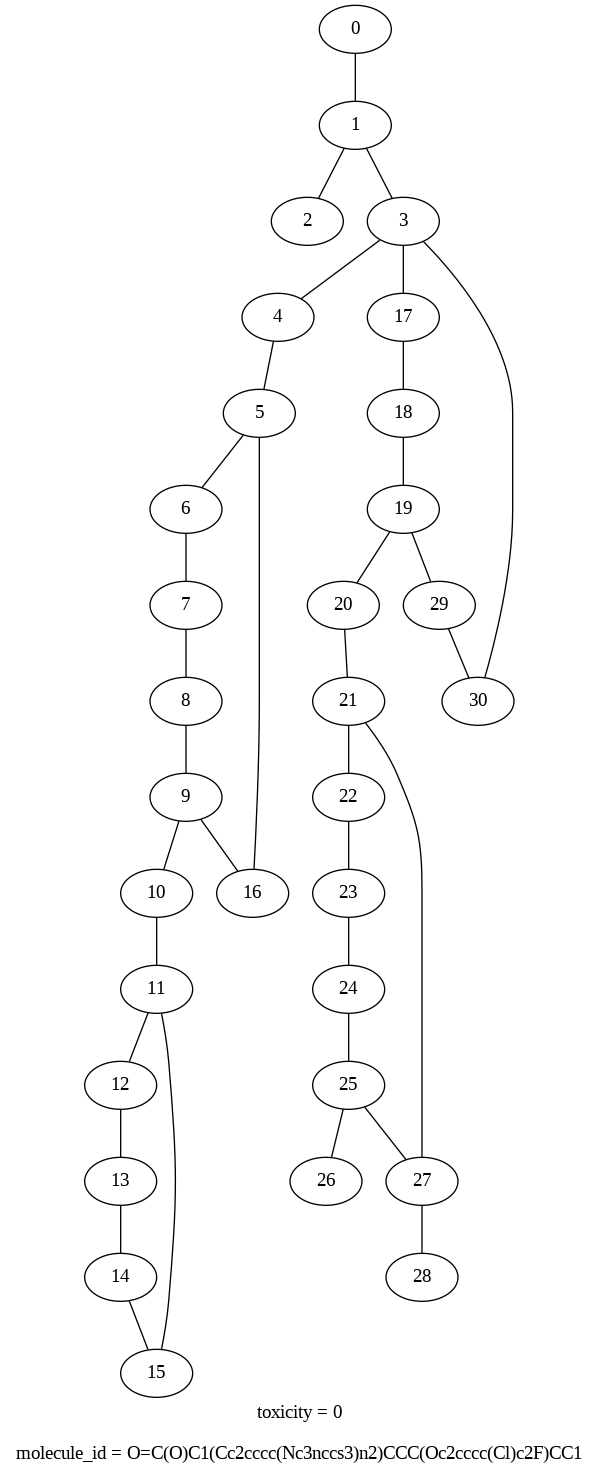

In [20]:
draw_molecule(graph_tensor)

GNN PreProcesing Layer


In [21]:
def get_initial_map_features(hidden_size, activation='relu'):
    """
    Initial pre-processing layer for a GNN (use as a class constructor).
    """
    def node_sets_fn(node_set, node_set_name):
        if node_set_name == 'atom':
            return tf.keras.layers.Dense(units=hidden_size, activation=activation)(node_set['atom_features'])

    def edge_sets_fn(edge_set, edge_set_name):
        if edge_set_name == 'bond':
            return tf.keras.layers.Dense(units=hidden_size, activation=activation)(edge_set['bond_features'])

    return tfgnn.keras.layers.MapFeatures(node_sets_fn=node_sets_fn,
                                          edge_sets_fn=edge_sets_fn,
                                          name='graph_embedding')

In [22]:
graph_embedding = get_initial_map_features(hidden_size=128)
#sets the number of hidden units in the dense layers to 128

In [23]:
batch_size = 64
batched_train_dataset = train_dataset.batch(batch_size)
#grouping consecutive elements of the dataset into batches. The batch_size parameter determines the number of elements in each batch.

In [24]:
graph_tensor_batch = next(iter(batched_train_dataset))
graph_tensor_batch.rank

1

In [25]:
graph_tensor_batch.node_sets['atom']['atom_features'].shape
graph_tensor_batch.edge_sets['bond']['bond_features'].shape

TensorShape([64, None, 12])

In [26]:
scalar_graph_tensor = graph_tensor_batch.merge_batch_to_components()
scalar_graph_tensor.rank

0

In [27]:
embedded_graph = graph_embedding(scalar_graph_tensor)
#It passes the scalar_graph_tensor through the graph_embedding layer to obtain the embedded representation of the graph.

In [28]:
embedded_graph.node_sets['atom'].features

{'hidden_state': <tf.Tensor: shape=(1562, 128), dtype=float32, numpy=
array([[0.        , 0.        , 0.2505649 , ..., 0.13627534, 0.0054878 ,
        0.        ],
       [0.        , 0.        , 0.10854989, ..., 0.281776  , 0.        ,
        0.        ],
       [0.        , 0.        , 0.10854989, ..., 0.281776  , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.57229686, ..., 0.21351361, 0.        ,
        0.1424334 ],
       [0.        , 0.        , 0.6335486 , ..., 0.5030669 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.45647454, ..., 0.56208825, 0.        ,
        0.        ]], dtype=float32)>}

In [29]:
embedded_graph.edge_sets['bond'].features

{'hidden_state': <tf.Tensor: shape=(3370, 128), dtype=float32, numpy=
array([[0.        , 0.4103431 , 0.        , ..., 0.10970341, 0.4382473 ,
        0.        ],
       [0.        , 0.4103431 , 0.        , ..., 0.10970341, 0.4382473 ,
        0.        ],
       [0.        , 0.09852085, 0.        , ..., 0.06564828, 0.15134813,
        0.        ],
       ...,
       [0.        , 0.24268883, 0.        , ..., 0.17677099, 0.4252922 ,
        0.        ],
       [0.        , 0.24268883, 0.        , ..., 0.17677099, 0.4252922 ,
        0.        ],
       [0.        , 0.24268883, 0.        , ..., 0.17677099, 0.4252922 ,
        0.        ]], dtype=float32)>}

In [30]:
class MPNN(tf.keras.layers.Layer):
    """
    A basic stack of message-passing Graph Attention layers.
    """
    def __init__(self, hidden_size, hops, name='gat_mpnn', **kwargs):
        self.hidden_size = hidden_size
        self.hops = hops
        super().__init__(name=name, **kwargs)

        self.mp_layers = [self._mp_factory(name=f'message_passing_{i}') for i in range(hops)]

    def _mp_factory(self, name):
        return gat_v2.GATv2GraphUpdate(num_heads=1,
                                       per_head_channels=self.hidden_size,
                                       edge_set_name='bond',
                                       sender_edge_feature=tfgnn.HIDDEN_STATE,
                                       name=name)

    def get_config(self):
        config = super().get_config()
        config.update({
            'hidden_size': self.hidden_size,
            'hops': self.hops
        })
        return config

    def call(self, graph_tensor):
        for layer in self.mp_layers:
            graph_tensor = layer(graph_tensor)
        return graph_tensor

In [31]:
mpnn = MPNN(hidden_size=128, hops=20)

In [32]:
def vanilla_mpnn_model(graph_tensor_spec, init_states_fn, pass_messages_fn):
    """
    Chain an initialization layer and a message-passing stack to produce a `tf.keras.Model`.
    """
    graph_tensor = tf.keras.layers.Input(type_spec=graph_tensor_spec)
    embedded_graph = init_states_fn(graph_tensor)
    hidden_graph = pass_messages_fn(embedded_graph)
    return tf.keras.Model(inputs=graph_tensor, outputs=hidden_graph)

In [33]:
model = vanilla_mpnn_model(graph_tensor_spec=graph_spec,
                           init_states_fn=graph_embedding,
                           pass_messages_fn=mpnn)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [()]                      0         
                                                                 
 graph_embedding (MapFeature  ()                       5248      
 s)                                                              
                                                                 
 gat_mpnn (MPNN)             ()                        990720    
                                                                 
Total params: 995,968
Trainable params: 995,968
Non-trainable params: 0
_________________________________________________________________


In [34]:
def get_model_creation_fn(hidden_size, hops, activation='relu', l2_coefficient=1e-3):
    """
    Return a model constructor for a given set of hyperparameters.
    """
    def model_creation_fn(graph_tensor_spec):
        initial_map_features = get_initial_map_features(hidden_size=hidden_size, activation=activation)
        mpnn = MPNN(hidden_size=hidden_size, hops=hops)

        model = vanilla_mpnn_model(graph_tensor_spec=graph_tensor_spec,
                                   init_states_fn=initial_map_features,
                                   pass_messages_fn=mpnn)
        model.add_loss(lambda: tf.reduce_sum([tf.keras.regularizers.l2(l2=l2_coefficient)(weight) for weight in model.trainable_weights]))
        return model
    return model_creation_fn

In [35]:
mpnn_creation_fn = get_model_creation_fn(hidden_size=256, hops=16)

In [36]:
model = mpnn_creation_fn(graph_spec)
model.summary()
model.compile()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [()]                      0         
                                                                 
 graph_embedding (MapFeature  ()                       10496     
 s)                                                              
                                                                 
 gat_mpnn (MPNN)             ()                        3158016   
                                                                 
Total params: 3,168,512
Trainable params: 3,168,512
Non-trainable params: 0
_________________________________________________________________


In [37]:
def extract_labels(graph_tensor):
    """
    Extract the toxicity class label from the `GraphTensor` representation of a molecule.
    Return a pair compatible with the `tf.keras.Model.fit` method.
    """
    return graph_tensor, graph_tensor.context['toxicity']

In [38]:
class GraphBinaryClassification(runner.GraphBinaryClassification):
    """
    A GraphBinaryClassification task with a hidden layer in the prediction head, and additional metrics.
    """
    def __init__(self, hidden_dim, *args, **kwargs):
        self._hidden_dim = hidden_dim
        super().__init__(*args, **kwargs)

    def adapt(self, model):
        hidden_state = tfgnn.pool_nodes_to_context(model.output,
                                                   node_set_name=self._node_set_name,
                                                   reduce_type=self._reduce_type,
                                                   feature_name=self._state_name)

        hidden_state = tf.keras.layers.Dense(units=self._hidden_dim, activation='relu', name='hidden_layer')(hidden_state)

        logits = tf.keras.layers.Dense(units=self._units, name='logits')(hidden_state)

        return tf.keras.Model(inputs=model.inputs, outputs=logits)

    def metrics(self):
        return (*super().metrics(), AUROC(name='AUROC'))

In [39]:
task = GraphBinaryClassification(hidden_dim=256, node_set_name='atom', num_classes=2)

In [40]:
trainer = runner.KerasTrainer(strategy=tf.distribute.get_strategy(), model_dir='model')

In [41]:
class AUROC(tf.keras.metrics.AUC):
    """
    AUROC metric computation for binary classification from logits.

    y_true: true labels, with shape (batch_size,)
    y_pred: predicted logits, with shape (batch_size, 2)
    """
    def update_state(self, y_true, y_pred, sample_weight=None):
        super().update_state(y_true, tf.math.softmax(y_pred, axis=-1)[:,1])

In [42]:
class GraphBinaryClassification(runner.GraphBinaryClassification):
    """
    A GraphBinaryClassification task with a hidden layer in the prediction head, and additional metrics.
    """
    def __init__(self, hidden_dim, *args, **kwargs):
        self._hidden_dim = hidden_dim
        super().__init__(*args, **kwargs)

    def adapt(self, model):
        hidden_state = tfgnn.pool_nodes_to_context(model.output,
                                                   node_set_name=self._node_set_name,
                                                   reduce_type=self._reduce_type,
                                                   feature_name=self._state_name)

        hidden_state = tf.keras.layers.Dense(units=self._hidden_dim, activation='relu', name='hidden_layer')(hidden_state)

        logits = tf.keras.layers.Dense(units=self._units, name='logits')(hidden_state)

        return tf.keras.Model(inputs=model.inputs, outputs=logits)


In [43]:
runner.run(
    train_ds_provider=train_dataset_provider,
    valid_ds_provider=valid_dataset_provider,
    feature_processors=[extract_labels],
    model_fn=get_model_creation_fn(hidden_size=128, hops=16),
    task=task,
    trainer=trainer,
    epochs=100,
    optimizer_fn=tf.keras.optimizers.Adam,
    gtspec=graph_spec,
    global_batch_size=128
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_6/gat_mpnn/message_passing_15/node_set_update_15/gat_v2_conv/Reshape_3:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_6/gat_mpnn/message_passing_15/node_set_update_15/gat_v2_conv/Reshape_2:0", shape=(None, 1, 1), dtype=float32), dense_shape=Tensor("gradient_tape/model_6/gat_mpnn/message_passing_15/node_set_update_15/gat_v2_conv/Cast:0", shape=(3,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_6/gat_mpnn/message_passing_15/node_set_update_15/gat_v2_conv/Reshape_6:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_6/gat_

50/50 [==============================] - 55s 882ms/step - loss: 0.5455 - sparse_categorical_accuracy: 0.7256 - sparse_categorical_crossentropy: 0.5455 - AUROC: 0.6527 - val_loss: 0.5153 - val_sparse_categorical_accuracy: 0.7279 - val_sparse_categorical_crossentropy: 0.5153 - val_AUROC: 0.7292
Epoch 2/100
50/50 [==============================] - 42s 844ms/step - loss: 0.4949 - sparse_categorical_accuracy: 0.7417 - sparse_categorical_crossentropy: 0.4949 - AUROC: 0.7499 - val_loss: 0.4905 - val_sparse_categorical_accuracy: 0.7500 - val_sparse_categorical_crossentropy: 0.4905 - val_AUROC: 0.7761
Epoch 3/100
50/50 [==============================] - 40s 800ms/step - loss: 0.4628 - sparse_categorical_accuracy: 0.7697 - sparse_categorical_crossentropy: 0.4628 - AUROC: 0.7937 - val_loss: 0.4717 - val_sparse_categorical_accuracy: 0.7663 - val_sparse_categorical_crossentropy: 0.4717 - val_AUROC: 0.8079
Epoch 4/100
50/50 [==============================] - 40s 798ms/step - loss: 0.4266 - sparse_ca

/usr/local/lib/python3.10/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:522: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.GraphTensorSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/usr/local/lib/python3.10/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:522: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.ContextSpec.v2; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/usr/local/lib/python3.10/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:522: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.NodeSetSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D
import numpy as np

# Define the CNN model
def create_model():
    model = Sequential()

    # Encoder
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(None, None, 1)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', strides=(2, 2), padding='same'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', strides=(2, 2), padding='same'))

    # Decoder
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(2, kernel_size=(3, 3), activation='tanh', padding='same'))

    return model





In [45]:
# Create the model
model = create_model()


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Load pre-trained weights (if available)
# model.load_weights('colorization_model_weights.h5')

# Load the input black and white image
# Assuming the input image is in grayscale and has the shape (height, width, 1)
input_image = np.load('input_image.npy')



In [ ]:

# Preprocess the input image
input_image = np.expand_dims(input_image, axis=0)

# Normalize the input image
input_image = input_image.astype('float32') / 255.0

# Predict the output color image
output_image = model.predict(input_image)

# Denormalize the output image
output_image = (output_image * 255.0).astype('uint8')


In [ ]:
# Save the output color image
# Assuming you want to save the output as 'output_image.jpg'
# You can change the output format as per your requirement
output_image_path = 'output_image.jpg'
Image.fromarray(output_image[0]).save(output_image_path)

# Print the predicted output color image
print("Output image saved at:", output_image_path)

Validation AUROC accuracy = 90.24%